# Voter System Simulation

Joshua Sanz, Robert Wang, Victor Han

In this project, we explore voter models. In our setup, a graph is generated to represent connections between voters. Each voter either has a belief or is neutral and affects its connected voters.

In [63]:
# a bit of setup
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import time


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# import our homemade voter and related classes
from VoterModel import VoterModel
from graphs import *
from vm_change import *

## Convergence Time Simulations
Now that the setup is done, let us first observe the behavior of these voter models for three specific scenarios. That is, let us take two types of graphs and two types of initializations and observe the time it takes for them to converge.

### n-complete graph
We start with a graph that is fully connected. Each voter is connected to every other and initialized with a unique belief. We plot this convergence time vs. the number of nodes. Initially, the voting is set to 'single_neighbor' with each voter affecting a single neighbor on an exponential clock. These settings can be changed in the line

    vm = VoterModel(graph=er, voting='single_neighbor', clock='exponential')
                    
The possible voting methods are 

    voting_methods = ('simple', 'probability', 'weighted_prob', 'single_neighbor')
    
For 'simple', the majority non-neutral vote wins and the update is probabilistically accepted. The 'single_neighbor' method is equivalent to 'simple' in the discrete time setting, but in the exponential clock setting, only a single neighbor of a voter is affected each time that voter's exponential clock goes off.
For 'probability', the belief that is updated is chosen probabilistically and then probabilistically accepted. For 'weighted_prob', we have the same as 'probability', except now we also have weights to the beliefs. These belief weights affect the update probability and update as well when a voter changes his/her belief.


In [85]:
# Convergence Time as a Function of n for an n-complete graph 

conv_time_arr = []

for n in range(2,76):
    er = complete_graph(n)
    vm = VoterModel(graph=er, voting='single_neighbor', clock='exponential')
    vm.redraw = False
    vm.initialize('all_unique')
    beliefs = list(set([v.belief[0] for v in vm._voters]))
    flux_arr = []
    belief_arr = []
    time_arr = []
    #vm.draw()
    #plt.show()

    ub = beliefs
    ctr = 0

    # Average over 5 runs
    conv_time_arr.append(0)
    for _ in range(5):
        while len(set(ub)) != 1 and ctr < 10000:
            ctr += 1
            cb, ub, ta = vm.update()
            flux_arr, belief_arr, time_arr = track_changes(cb, ub, ta, flux_arr, belief_arr, time_arr, beliefs)

        conv_time_arr[-1] += convergence_time(time_arr, belief_arr) / 5.

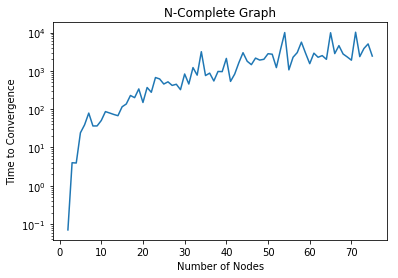

In [69]:
plt.plot(range(2,76),conv_time_arr)
plt.xlabel('Number of Nodes')
plt.ylabel('Time to Convergence')
plt.title('N-Complete Graph')
plt.yscale('log')
plt.show()

### n-ring graph
Now we do the same as above for an n-ring graph.

In [71]:
# Convergence Time as a Function of n for an n-ring graph 

conv_time_arr = []

for n in range(2,51):
    er = cycle(n)
    vm = VoterModel(graph=er, voting='single_neighbor', clock='exponential')
    vm.redraw = False
    vm.initialize('all_unique')
    beliefs = list(set([v.belief[0] for v in vm._voters]))
    flux_arr = []
    belief_arr = []
    time_arr = []
    #vm.draw()
    #plt.show()

    ub = beliefs
    ctr = 0

    # Average over 5 runs
    conv_time_arr.append(0)
    for _ in range(5):
        while len(set(ub)) != 1 and ctr < 50000:
            ctr += 1
            cb, ub, ta = vm.update()
            flux_arr, belief_arr, time_arr = track_changes(cb, ub, ta, flux_arr, belief_arr, time_arr, beliefs)

        conv_time_arr[-1] += convergence_time(time_arr, belief_arr) / 5.

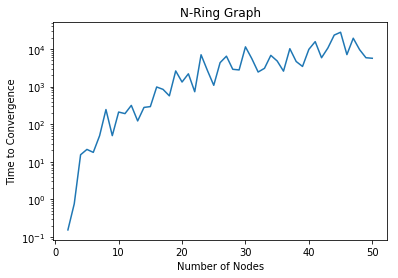

In [72]:
plt.plot(range(2,51),conv_time_arr)
plt.xlabel('Number of Nodes')
plt.ylabel('Time to Convergence')
plt.title('N-Ring Graph')
plt.yscale('log')
plt.show()

### Competition Between Two Beliefs in N-Ring Graph
Now let us take the n-ring graph and observe what happens when there is a competition between only two beliefs. All voters are initialized as one belief or another. N, the number of nodes in the graph, can easily be experimented with. We plot the time it takes for a single belief to dominate vs the number of people initially supporting one of the beliefs.

In [73]:
# Competition Between Two Beliefs in N-Ring Graph
# Fix N = 20
N = 20
er = cycle(N)
vm = VoterModel(graph=er, voting='single_neighbor', clock='exponential')
vm.redraw = False

conv_time_arr = []

for i in range(1,20):
    vm.initialize('all_rand_two',k=i)
    beliefs = list(set([v.belief[0] for v in vm._voters]))
    flux_arr = []
    belief_arr = []
    time_arr = []
    
    ub = beliefs
    ctr = 0
    
    # Average over 5 runs
    conv_time_arr.append(0)
    for _ in range(5):
        while len(set(ub)) != 1 and ctr < 10000:
            ctr += 1
            cb, ub, ta = vm.update()
            flux_arr, belief_arr, time_arr = track_changes(cb, ub, ta, flux_arr, belief_arr, time_arr, beliefs)

        conv_time_arr[-1] += convergence_time(time_arr, belief_arr) / 5.

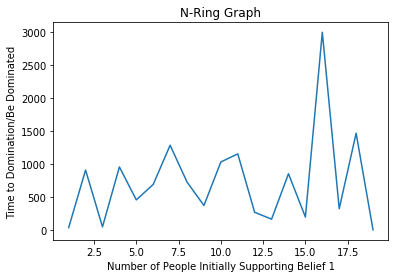

In [74]:
plt.plot(range(1,20),conv_time_arr)
plt.xlabel('Number of People Initially Supporting Belief 1')
plt.ylabel('Time to Domination/Be Dominated')
plt.title('N-Ring Graph')
plt.show()

## More Simulation Options
Now that we have some idea about convergence properties, we can also explore the model more and have fun with visualizing more things.

### Visualizing the graph state over time
Let us observe plots of the graphs for a fixed number of nodes as well as plots summarizing how beliefs change. The resulting graph figures can be saved as gifs to replay later.

### Types of graphs
Below are a few examples of graphs we can use. Comment/uncomment your favorites to try them out! Also, feel free to change the graph size.

In [87]:
N = 10
er = erdos_renyi(N, 0.5)
#er = complete_graph(N)
#er = cycle(N)
#er = torus_2d(5,2)

### Types of visuals
In viewing the plots we also have many visualization options. The following are implemented.

    visualization_methods = ('shell', 'random', 'kamada_kawai', 'spring', 'spectral', 'circular')
    
These visualization methods are all based on the networkx built in layout methods. With the exception of 'shell' and 'kamada_kawai', all of the visualization methods set an intial graph layout and keep the same graph layout everytime it is drawn. The 'shell' visualization method is best used when there are many neutral voters and we would like to see the separation between neutral and nonneutral voters. As for 'kamada_kawai', it simply creates a new kamada_kawai layout each time the graph is drawn. The visual type is set by the visualization parameter when instantiating the voter model.

In [88]:
# vm = VoterModel(graph = er, voting='simple', visualization='shell')
# vm = VoterModel(graph = er, voting='probability', visualization='shell')
vm = VoterModel(graph=er, voting='weighted_prob', visualization='spring')

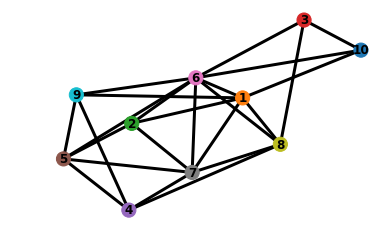

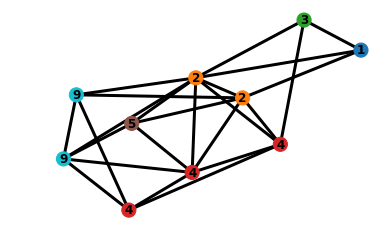

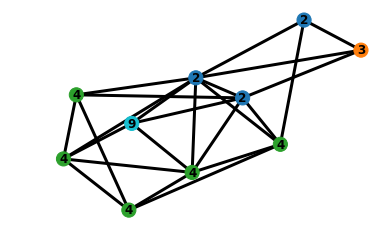

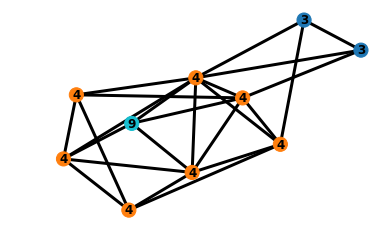

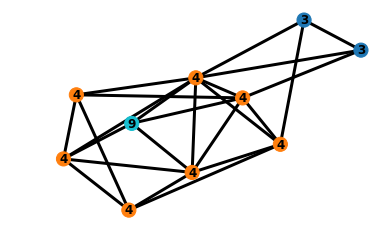

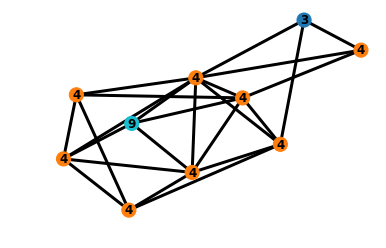

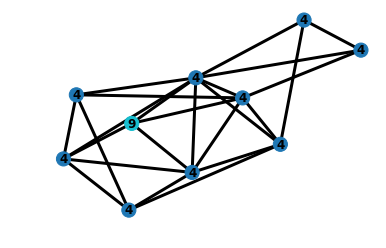

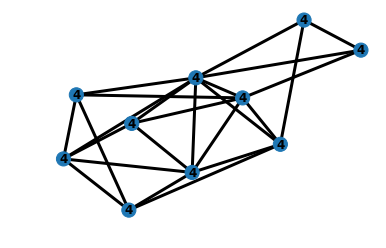

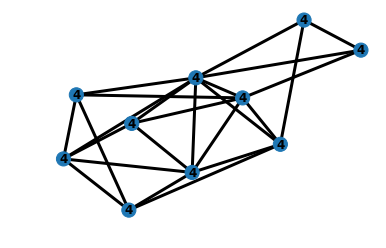

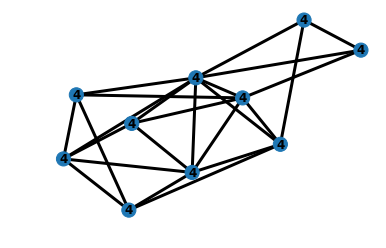

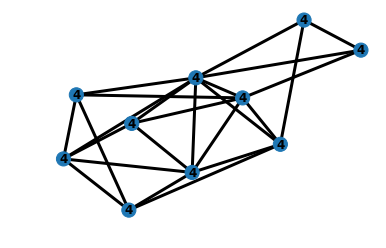

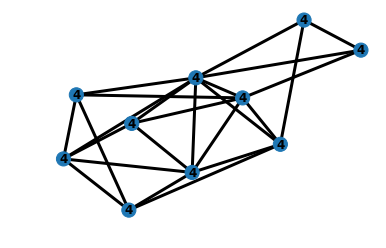

In [89]:
vm.initialize('all_unique')
beliefs = list(set([v.belief[0] for v in vm._voters]))
flux_arr = []
belief_arr = []
time_arr = []

vm.draw()
plt.show()
for i in range(50):
    cb, ub, ta = vm.update()
    flux_arr, belief_arr, time_arr = track_changes(cb, ub, ta, flux_arr, belief_arr, time_arr, beliefs)
    if i % 5 == 0:
        vm.draw()
        plt.show()
vm.draw()
plt.show()

# Save the resulting images as a gif
vm.save_gif(fps=0.2, fname='sim1.gif')

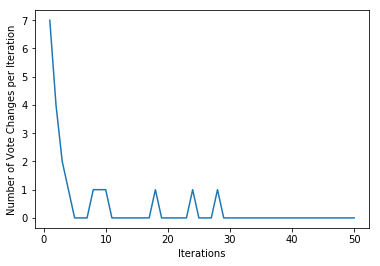

In [90]:
# Plot the average number of belief changes per iteration
if vm.clock == "discrete":
    plt.figure()
    plot_flux(flux_arr)

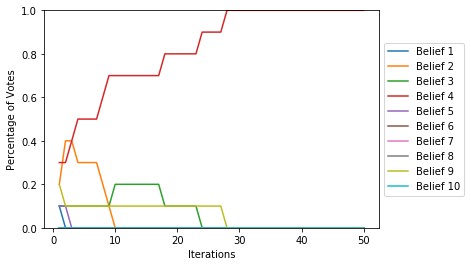

In [91]:
# Plot the distribution of beliefs per iteration
if vm.clock == 'discrete':
    plt.figure()
    plot_comparisons(belief_arr, beliefs)

In [92]:
convergence_time(time_arr, belief_arr)

28

### Graph animations
If we don'y want to see a new plot each time, but rather the same figure updating, we can run an animation. To do this, we need to add an extra %matplotlib notebook command magic, and we add redraw=True when instantiating VoterModel.

<IPython.core.display.Javascript object>


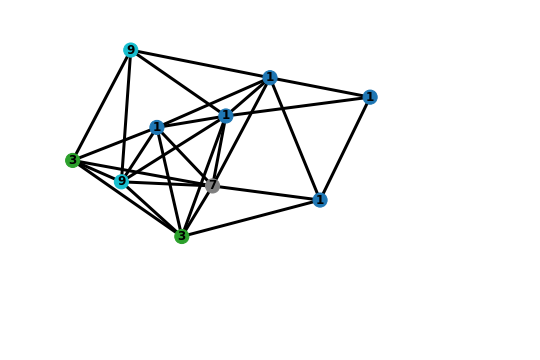

In [94]:
# Here we demonstrate an animation. The resulting animation is also saved to a gif.
# The below magic command is needed for the animation.
%matplotlib notebook
N = 10
er = erdos_renyi(N, 0.5)
vm = VoterModel(graph=er, voting='weighted_prob', visualization='spring', redraw=True)
vm.initialize('all_unique')
beliefs = list(set([v.belief[0] for v in vm._voters]))
flux_arr = []
belief_arr = []
time_arr = []
vm.draw()
plt.show()

for i in range(10):
    cb, ub, ta = vm.update()
    plt.pause(0.1)
    flux_arr, belief_arr, time_arr = track_changes(cb, ub, ta, flux_arr, belief_arr, time_arr, beliefs)
    vm.draw()
    
vm.save_gif(fps=0.2, fname='sim2.gif')
%matplotlib inline

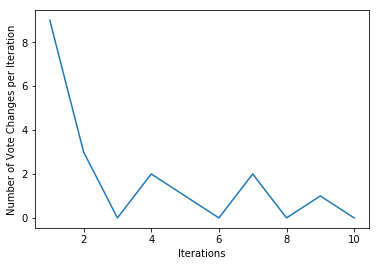

In [95]:
# Plot the number of belief changes per iteration
if vm.clock == 'discrete':
    plt.figure()
    plot_flux(flux_arr)

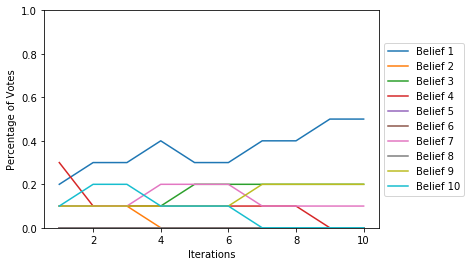

In [96]:
# Plot the distribution of beliefs per iteration
if vm.clock == 'discrete':
    plt.figure()
    plot_comparisons(belief_arr, beliefs)

In [97]:
convergence_time(time_arr,belief_arr)

10